In [1]:
import torch
import torch.distributions as D
import numpy as np
import random

/private/home/arjunsub/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def set_seed(seed = 42):
    # Torch RNG
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # Python RNG
    np.random.seed(seed)
    random.seed(seed)

In [3]:
set_seed()
seed_list=[]
n_runs=10
for i in range(n_runs):
    seed_list.append(random.randint(1,100))
print(seed_list)

[82, 15, 4, 95, 36, 32, 29, 18, 95, 14]


In [4]:
class LR(torch.nn.Module):
    def __init__(self):
        super(LR, self).__init__()
        self.linear = torch.nn.Linear(k, 1, bias=False)

    def forward(self, x):
        out = self.linear(x)
        return out

In [5]:
N_train = 200
alpha = 3
N_test = 100000

k = 2000
w_star_0 = 1 / torch.arange(1, k + 1).reshape(-1, 1)
w_star_1 = 2 / torch.arange(1, k + 1).reshape(-1, 1)
# w_star_0 = 0.5 * torch.ones((k, 1))
# w_star_1 = torch.ones((k, 1))

noise_sigma = 1
noise = D.Normal(0, noise_sigma)

In [6]:
p_list = torch.arange(0.0, 1.1, 0.1)

excess_risk_list = torch.zeros((p_list.size(0), n_runs))
k_star_list = torch.zeros((p_list.size(0), n_runs))
bias_list = torch.zeros((p_list.size(0), n_runs))
var_list = torch.zeros((p_list.size(0), n_runs))
bound_list = torch.zeros((p_list.size(0), n_runs))

for p_i, p in enumerate(p_list):
    print('p {}'.format(p))
    mix = D.Categorical(torch.tensor([p, 1 - p]))
    # covars = 1 / (torch.arange(2, k + 2) * (torch.log(torch.arange(2, k + 2)) ** 2))
    covars = 1 / torch.pow(torch.arange(1, k + 1), 2)
    # covars[covars == 0] = 1e-14
    means_0 = 2 * covars
    means_1 = torch.zeros(k)
    comp = D.Independent(D.Normal(torch.cat([means_0.reshape(1, -1), \
                                             means_1.reshape(1, -1)]), \
                                  torch.cat([covars.reshape(1, -1) ** 0.5, \
                                             covars.reshape(1, -1) ** 0.5])), 1)
    eigs_0 = covars + means_0 ** 2
    eigs_1 = covars + means_1 ** 2
    
    # gmm = D.MixtureSameFamily(mix, comp)
    all_eigs = p * eigs_0 + (1 - p) * eigs_1
    gamma = 0.99 / (alpha * all_eigs.sum())
    # gamma = 1e-4
    assert gamma < 1 / (alpha * all_eigs.sum())
    print('gamma {}'.format(gamma))
    
    for seed_i, seed in enumerate(seed_list):
        # Generate training data
        set_seed(seed)
        x_train = []
        y_train = []
        for _ in range(N_train):
            idx = mix.sample()
            x_train.append(comp.sample()[idx].reshape(1, -1))
            if idx.item() == 0:
                y_train.append(torch.mm(x_train[-1], w_star_0) + noise.sample())
            else:
                y_train.append(torch.mm(x_train[-1], w_star_1))
        x_train = torch.cat(x_train)
        y_train = torch.cat(y_train)

        # Generate test data
        set_seed(seed)
        x_test = comp.sample((N_test,))[:, 0, :]
        y_test = torch.mm(x_test, w_star_0) + noise.sample((N_test, 1))

        set_seed(seed)
        model = LR()
        criterion = torch.nn.MSELoss() 
        optimizer = torch.optim.SGD(model.parameters(), lr=gamma)
#         with torch.no_grad():
#             model.linear.weight = torch.nn.Parameter(torch.zeros_like(w_star_0.reshape(1, -1)))

        # Train model
        model.train()
        w_list = []
        for epoch in range(N_train):
            w_list.append(model.linear.weight.detach())

            set_seed(seed)
            optimizer.zero_grad()
            outputs = model(x_train[epoch].reshape(1, -1))

            loss = criterion(outputs, y_train[epoch].reshape(1, -1)) / 2
            loss.backward()
            optimizer.step()

    #         if epoch == 0 or (epoch + 1) % 20 == 0:
    #             print('epoch {}, loss {}'.format(epoch + 1, loss.item()))

    #     print()
        model.eval()
        w_bar = torch.cat(w_list).mean(dim=0, keepdim=True)
        with torch.no_grad():
            model.linear.weight = torch.nn.Parameter(w_bar)
        outputs = model(x_test)
        loss = criterion(outputs, y_test)

        model.eval()
        with torch.no_grad():
            model.linear.weight = torch.nn.Parameter(w_star_0.reshape(1, -1))
        outputs = model(x_test)
        best_loss = criterion(outputs, y_test)

        excess_risk_list[p_i, seed_i] = loss.detach() - best_loss.detach()

        # Compute bias bound
        w_dist = ((w_list[0][0] - w_star_0[:, 0]) * (w_list[0][0] - w_star_0[:, 0])).sum()
        if all_eigs[0] >= 1 / (gamma * N_train):
            bias = eigs_0[0] * w_dist / ((gamma ** 2) * (N_train ** 2) * (all_eigs[0] ** 2))
        else:
            bias = eigs_0[0] * w_dist
        bias_list[p_i, seed_i] = bias

        # Compute k*
        nonz = (all_eigs < 1 / (gamma * N_train))
        # print(all_eigs, 1 / (gamma * N_train))
        k_star = ((nonz.cumsum(0) == 1) & nonz).long().argmax().item()
        
        k_star_list[p_i, seed_i] = k_star

        # Compute variance bound
        sigma_squared = torch.max(all_eigs ** -0.5 * \
                        (p * eigs_0 + (1 - p) * alpha * torch.sum(w_star_0 * eigs_1 * w_star_0) * eigs_1) * \
                         all_eigs ** -0.5)
        # print(sigma_squared)
        var = 2 * alpha / (gamma * N_train)
        w_dist = ((w_list[0][0] - w_star_0[:, 0])[:k_star] * (w_list[0][0] - w_star_0[:, 0])[:k_star]).sum() \
                        + N_train * gamma * ((w_list[0][0] - w_star_0[:, 0])[k_star:] * all_eigs[k_star:] * (w_list[0][0] - w_star_0[:, 0])[k_star:]).sum()
        var = (var * w_dist + sigma_squared) / (1 - gamma * alpha * all_eigs.sum())
        head = 1 / N_train * (eigs_0[:k_star] / all_eigs[:k_star]).sum()
        tail = N_train * (gamma ** 2) * (eigs_0[k_star:] * all_eigs[k_star:]).sum()
        var = var * (head + tail)
        var_list[p_i, seed_i] = var

        bound_list[p_i, seed_i] = 2 * bias + 2 * var
    
    print('excess risk {}'.format(excess_risk_list[p_i].mean().item()))
    print('bias {}'.format(bias_list[p_i].mean().item()))
    print('k* {}'.format(k_star_list[p_i].mean().item()))
    print('var {}'.format(var_list[p_i].mean().item()))
    print('excess risk bound {}'.format(bound_list[p_i].mean().item()))
    print('ratio {}'.format((bound_list[p_i] / excess_risk_list[p_i]).mean()))
    print()
    

p 0.0
gamma 0.20067696273326874
excess risk 6.434881687164307
bias 0.005741278640925884
k* 6.0
var 58.2935791015625
excess risk bound 116.5986557006836
ratio 18.140207290649414

p 0.10000000149011612
gamma 0.15885519981384277
excess risk 3.5349879264831543
bias 0.005749163683503866
k* 5.0
var 43.17591094970703
excess risk bound 86.36332702636719
ratio 50.890663146972656

p 0.20000000298023224
gamma 0.13145877420902252
excess risk 1.4780168533325195
bias 0.003929074853658676
k* 5.0
var 32.98237609863281
excess risk bound 65.97261047363281
ratio 138.62232971191406

p 0.30000001192092896
gamma 0.11212199181318283
excess risk 1.0423517227172852
bias 0.0037651516031473875
k* 4.0
var 25.96566390991211
excess risk bound 51.9388542175293
ratio 318.7381591796875

p 0.4000000059604645
gamma 0.09774443507194519
excess risk 0.9925247430801392
bias 0.0027071121148765087
k* 4.0
var 19.889789581298828
excess risk bound 39.78499221801758
ratio 229.61526489257812

p 0.5
gamma 0.086635060608387
excess r

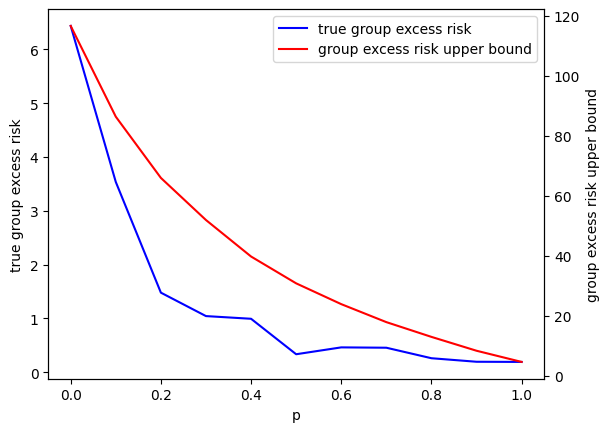

In [7]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots()
lns1 = ax1.plot(p_list, excess_risk_list.mean(dim=1), label='true group excess risk', c='b')
ax2 = ax1.twinx()
lns2 = ax2.plot(p_list, bound_list.mean(dim=1), label='group excess risk upper bound', c='r')
# plt.plot(p_list, (bound_list / excess_risk_list).mean(dim=1), label='ratio')
lns = lns1+lns2
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc=0)
ax1.set_xlabel('p')
ax1.set_ylabel('true group excess risk')
ax2.set_ylabel('group excess risk upper bound')
# plt.title('N = {}'.format(N_train))
plt.show()